In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os

In [3]:
def translate_grid_to_origin(x: np.ndarray, y: np.ndarray, dx: float, dy: float) -> (np.ndarray, np.ndarray):
    trans_x = x + dx
    trans_y = y + dy
    
    return trans_x,trans_y

def get_grid_angle(x0: float, y0: float, x1: float, y1: float)-> float:
    grid_angle = np.arctan2(y1 - y0, x1 - x0)

    return grid_angle

def rotate_grid(x: np.ndarray, y: np.ndarray, x0: float, y0: float, rotation_angle: float) -> (np.ndarray, np.ndarray):
    x_translated_to_zero, y_translated_to_zero = translate_grid_to_origin(x, y, -x0, -y0)

    x_rotated = np.cos(rotation_angle) * x_translated_to_zero - np.sin(rotation_angle) * y_translated_to_zero
    y_rotated = np.sin(rotation_angle) * x_translated_to_zero + np.cos(rotation_angle) * y_translated_to_zero

    x_translated_back, y_translated_back = translate_grid_to_origin(x_rotated, y_rotated, x0, y0)

    return x_translated_back, y_translated_back

In [4]:
particle_folder = r"D:\geneva_forecast\ctracker\results"
#particles = xr.open_dataset(os.path.join(particle_folder, "PT_2409_2609_geneva_run.nc"))
particles = xr.open_dataset(os.path.join(particle_folder, "PT_1709_2509_geneva_run.nc"))

In [5]:
x_wwtp, y_wwtp = 534650,151350 

In [6]:
snapshot_particles = particles.sel(time=particles['time'][-79].values)

In [7]:
# point of origin in swiss grid 
XO_SG = 500000
YO_SG = 116500

# second point for tilted grid
X1_SG = 563000
Y1_SG = 138700

time_plot = particles['time'][0].values
# XY on mitgcm grid 
x = snapshot_particles['xtrack'].values
y = snapshot_particles['ytrack'].values

angle = get_grid_angle(XO_SG, YO_SG, X1_SG, Y1_SG)

In [8]:
# XY on swiss grid 
x_sg = x + XO_SG
y_sg = y + YO_SG

In [9]:
x_rotated, y_rotated = rotate_grid(x_sg, y_sg, XO_SG, YO_SG, angle)

In [10]:
x_rotated[x_rotated > 10**10] = x_wwtp
y_rotated[y_rotated > 10**10] = y_wwtp

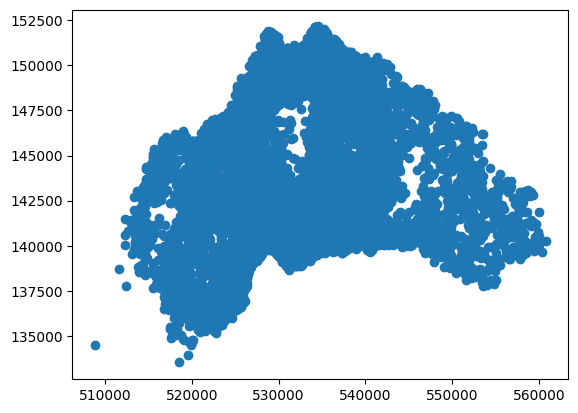

In [11]:
plt.scatter(x_rotated, y_rotated)

In [15]:
path_out = os.path.join(particle_folder, "PT_1709_2509_geneva_run_ch1903.txt")

In [16]:
np.savetxt(path_out, np.column_stack((x_rotated, y_rotated)))

In [ ]:
x_wwtp, y_wwtp = 534650,151350 
xy_land = np.loadtxt(os.path.join(particle_folder, "shoreline.txt"))

In [ ]:
x_rotated[x_rotated > 10**10] = x_wwtp
y_rotated[y_rotated > 10**10] = y_wwtp

In [ ]:
%matplotlib notebook

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(x_rotated.flatten(), y_rotated.flatten(),label='after rotation')
ax.plot(xy_land[:,0], xy_land[:,1], label='shoreline', color='grey')
ax.scatter(x_wwtp, y_wwtp, color='red')
ax.legend()
plt.show()

In [ ]:
import holoviews as hv
hv.extension('bokeh')

In [ ]:
shoreline = hv.Curve(xy_land)
shoreline = shoreline.opts(tools=['hover'], width=1600, height=800, title= str(time_plot))

In [ ]:
particles_point = hv.Points(np.array([x_rotated.flatten(), y_rotated.flatten()]).transpose())
particles_point = particles_point.opts(tools=['hover'], color='red', marker='o', size=5)

In [ ]:
shoreline*particles_point

In [ ]:
tap_stream = hv.streams.Tap(source=particles_point, x=np.nan, y=np.nan)

# Define a callback to display coordinates where the user clicks
def display_click_info(x, y):
    if not np.isnan(x) and not np.isnan(y):
        return hv.Text(x, y, f'({x:.2f}, {y:.2f})').opts(text_color='black', fontsize=12)
    return hv.Text(0, 0, '')  # If no valid click, return an empty Text element

# Create a DynamicMap to update the coordinates on click
click_info = hv.DynamicMap(lambda x, y: display_click_info(x, y), streams=[tap_stream])

# Combine everything into one plot
plot = shoreline * particles_point * click_info
plot

In [ ]:
import holoviews as hv
import numpy as np

# Enable HoloViews extension (required)
hv.extension('bokeh')

# Sample data for your shoreline and particles
xy_land = np.array([[0, 1, 2], [0, 1, 2]])  # Replace with your actual data
x_rotated = np.random.random(100)  # Replace with your actual data
y_rotated = np.random.random(100)  # Replace with your actual data
time_plot = 'Shoreline and Particles'

# Create the shoreline curve
shoreline = hv.Curve(xy_land)
shoreline = shoreline.opts(tools=['hover'], width=800, height=400, title=str(time_plot))

# Create the particles point plot
particles_point = hv.Points(np.array([x_rotated.flatten(), y_rotated.flatten()]).transpose())
particles_point = particles_point.opts(tools=['hover'], color='red', marker='o', size=5)

# Define a stream for capturing click (tap) events
tap_stream = hv.streams.Tap(source=particles_point, x=np.nan, y=np.nan)

# Define a callback to display coordinates where the user clicks
def display_click_info(x, y):
    print(x)
    if not np.isnan(x) and not np.isnan(y):
        return hv.Text(x, y, f'({x:.2f}, {y:.2f})').opts(text_color='black', fontsize=12)
    return hv.Text(0, 0, '')  # Return an empty Text if no valid click

# Create a DynamicMap to update the coordinates on click
click_info = hv.DynamicMap(lambda x, y: display_click_info(x, y), streams=[tap_stream])

# Combine everything into one plot
plot = shoreline * particles_point * click_info

# Show the plot
plot.opts(tools=['tap', 'hover'])
